In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.analytics import analysis 
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys
import pytz

In [2]:
day_to_analyze = datetime.strptime("2020-10-05", "%Y-%m-%d")

In [3]:
trades = analysis.load_trades(day_to_analyze)

In [4]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price,expire_tstamp,batch_id
0,38443,4752,AG,buy,260,10.04,"{'buy': {'avg': 9.8796, 'macd': [0.01044463433...",2020-10-05 14:26:25.943458+00:00,2020-10-05 14:26:26.642208,9.68,11.12,None,3a735998-48e2-497d-bf05-e903eafbc715
1,38790,4752,AG,sell,260,9.92,"{'buy': None, 'sell': {'liquidation': 1}}",2020-10-05 19:45:07.014774+00:00,2020-10-05 19:46:13.319146,9.68,11.12,None,3a735998-48e2-497d-bf05-e903eafbc715
2,38447,4754,AKBA,buy,869,2.66,"{'buy': {'avg': 2.6144, 'macd': [0.00728963547...",2020-10-05 14:28:09.380335+00:00,2020-10-05 14:28:11.051319,2.56,2.99,None,3a735998-48e2-497d-bf05-e903eafbc715
3,38787,4754,AKBA,sell,869,2.66,"{'buy': None, 'sell': {'avg': 2.6302, 'rsi': [...",2020-10-05 19:10:11.318238+00:00,2020-10-05 19:11:36.844967,2.56,2.99,None,3a735998-48e2-497d-bf05-e903eafbc715
4,38446,4752,AKER,buy,939,2.36,"{'buy': {'avg': 2.3079, 'macd': [0.00611222318...",2020-10-05 14:28:09.025044+00:00,2020-10-05 14:28:09.948349,2.26,2.66,None,3a735998-48e2-497d-bf05-e903eafbc715
5,38786,4752,AKER,sell,939,2.26,"{'buy': None, 'sell': {'avg': 2.3435, 'rsi': [...",2020-10-05 18:58:54.530154+00:00,2020-10-05 19:00:37.641303,2.26,2.66,None,3a735998-48e2-497d-bf05-e903eafbc715
6,38435,4756,ALEC,buy,218,10.49,"{'buy': {'avg': 10.3693, 'macd': [0.0232217015...",2020-10-05 14:16:29.302613+00:00,2020-10-05 14:16:30.434601,10.06,11.78,None,3a735998-48e2-497d-bf05-e903eafbc715
7,38456,4756,ALEC,sell,218,10.78,"{'buy': None, 'sell': {'avg': 10.4939, 'rsi': ...",2020-10-05 15:08:09.412049+00:00,2020-10-05 15:08:09.788222,10.06,11.78,None,3a735998-48e2-497d-bf05-e903eafbc715
8,38422,4755,AMRN,sell,769,4.97,"{'buy': None, 'sell': {'avg': 4.9817, 'vwap': ...",2020-10-05 13:56:13.805310+00:00,2020-10-05 13:56:15.082711,5.02,4.81,None,3a735998-48e2-497d-bf05-e903eafbc715
9,38423,4755,AMRN,sell,1035,4.97,"{'buy': None, 'sell': {'avg': 4.9817, 'vwap': ...",2020-10-05 13:56:13.916435+00:00,2020-10-05 13:56:15.223829,5.02,4.81,None,3a735998-48e2-497d-bf05-e903eafbc715


In [5]:
algo_runs = analysis.load_runs(day_to_analyze)

In [5]:
symbol_name = []
counts = []
revenues = []

batch_ids = trades.batch_id.unique().tolist()

current_max = pd.options.display.max_rows
pd.set_option("display.max_rows", None)
for batch_id in batch_ids:
    how_was_my_day = pd.DataFrame()
    how_was_my_day["symbol"] = trades.loc[trades["batch_id"] == batch_id][
        "symbol"
    ].unique()
    how_was_my_day["revenues"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.calc_revenue(x, trades)
    )
    how_was_my_day["count"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.count_trades(x, trades)
    )

    print(
        f"batch_id:{batch_id}, total revenues=${round(sum(how_was_my_day['revenues']),2)}"
    )
    display(how_was_my_day)

pd.set_option("display.max_rows", current_max)

batch_id:3a735998-48e2-497d-bf05-e903eafbc715, total revenues=$56.23


,symbol,revenues,count
0,AG,-31.20,2
1,AKBA,0.00,2
2,AKER,-93.90,2
3,ALEC,63.22,2
4,AMRN,-54.12,3
5,AXGT,15.05,2
6,BEEM,4.05,2
7,CDE,-27.37,2
8,CGC,8.65,2
9,CTIC,0.00,2


In [6]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
minute_history = {}
for symbol in trades.symbol.unique().tolist():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol,
        1,
        "minute",
        _from=str((day_to_analyze - timedelta(days=10)).date()),
        to=str((day_to_analyze + timedelta(days=1)).date()),
    ).df

AG analysis with profit $-31.2


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2610.4,-2610.4,buy,2020-10-05 10:26:26.642208-04:00,10.04,260,2.19%,,"{'buy': {'avg': 9.8796, 'macd': [0.010444634334087155, 0.014053357364536723, 0.019113714640647927, 0.024456003507793866, 0.029160577366580398], 'vwap': 10.04, 'macd_signal': [0.013725852182150337, 0.013791353218627614, 0.014855825503031677, 0.016775861103984116, 0.019252804356503374]}, 'sell': None}",11.12,9.68
1,-31.2,2579.2,sell,2020-10-05 15:46:13.319146-04:00,9.92,260,0.97%,,"{'buy': None, 'sell': {'liquidation': 1}}",11.12,9.68


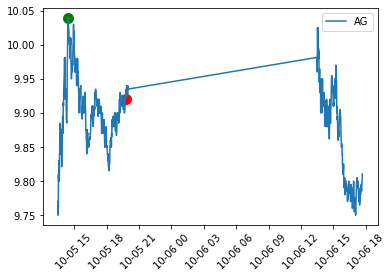

AKBA analysis with profit $0.0


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2311.54,-2311.54,buy,2020-10-05 10:28:11.051319-04:00,2.66,869,1.72%,,"{'buy': {'avg': 2.6144, 'macd': [0.007289635479466039, 0.006742807199626277, 0.007434120573545311, 0.0078910285380287, 0.010153380606634954], 'vwap': 2.6524, 'macd_signal': [0.006832217783347155, 0.00681433566660298, 0.006938292647991446, 0.0071288398259988965, 0.007733747982126108]}, 'sell': None}",2.99,2.56
1,0.00,2311.54,sell,2020-10-05 15:11:36.844967-04:00,2.66,869,1.72%,,"{'buy': None, 'sell': {'avg': 2.6302, 'rsi': [59.06835403514934, 59.06835403514934, 55.664478931886606], 'vwap': 2.6618, 'reasons': 'bail post whipsawed', 'movement': 0.0006766917293232337, 'sell_macd': [0.003973586493236425, 0.0039050922226202545, 0.00380100458028787, 0.0036705336306743774, 0.0033549649214861255], 'sell_macd_signal': [0.0034402906683827584, 0.0035332509792302576, 0.0035868016994417802, 0.0036035480856882996, 0.0035538314528478646]}}",2.99,2.56


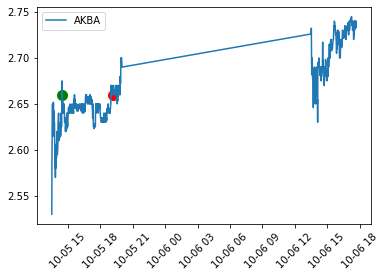

AKER analysis with profit $-93.9


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2216.04,-2216.04,buy,2020-10-05 10:28:09.948349-04:00,2.36,939,3.2%,,"{'buy': {'avg': 2.3079, 'macd': [0.006112223186677923, 0.008488825845873293, 0.01007062193674324, 0.011402563353387851, 0.013113884254139396], 'vwap': 2.3565, 'macd_signal': [0.003807959627222716, 0.004744132870952831, 0.005809430684110913, 0.006928057217966301, 0.00816522262520092]}, 'sell': None}",2.66,2.26
1,-93.90,2122.14,sell,2020-10-05 15:00:37.641303-04:00,2.26,939,-1.17%,,"{'buy': None, 'sell': {'avg': 2.3435, 'rsi': [37.36971485849326, 39.81435689472856, 36.782642280944096], 'vwap': 2.26, 'reasons': 'stopped', 'movement': -0.04237288135593224, 'sell_macd': [-0.004728895653855147, -0.005469669769213148, -0.006240796745216937, -0.006495690535022192, -0.007129429974674917], 'sell_macd_signal': [-0.005787049256995167, -0.0057235733594387635, -0.005827018036594398, -0.005960752536279957, -0.006194488023958949]}}",2.66,2.26


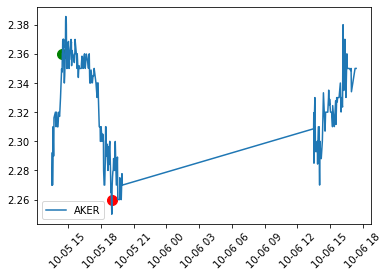

ALEC analysis with profit $63.22


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2286.82,-2286.82,buy,2020-10-05 10:16:30.434601-04:00,10.49,218,1.16%,,"{'buy': {'avg': 10.3693, 'macd': [0.023221701527489813, 0.024893442854443393, 0.02619872802109313, 0.028055589869367736, 0.030969591717795453], 'vwap': 10.4863, 'macd_signal': [0.023102792657519217, 0.02346092269690405, 0.024008483761741868, 0.024817904983267042, 0.026048242330172725]}, 'sell': None}",11.78,10.06
1,63.22,2350.04,sell,2020-10-05 11:08:09.788222-04:00,10.78,218,3.95%,,"{'buy': None, 'sell': {'avg': 10.4939, 'rsi': [72.03761639302321, 68.88127297587552, 63.935630521074835], 'vwap': 10.7849, 'reasons': 'bail', 'movement': 0.027645376549094294, 'sell_macd': [0.03513450347048952, 0.034731515564020654, 0.035119687123083665, 0.034332292401275666, 0.03248844856088873], 'sell_macd_signal': [0.03237429391218443, 0.03284573824255167, 0.03330052801865807, 0.03350688089518159, 0.03330319442832302]}}",11.78,10.06


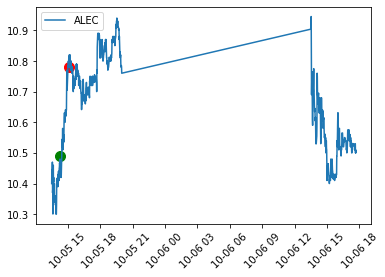

AMRN analysis with profit $-54.12


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,3821.93,3821.93,sell,2020-10-05 09:56:15.082711-04:00,4.97,769,3.54%,,"{'buy': None, 'sell': {'avg': 4.9817, 'vwap': 4.97, 'vwap_series': [4.985356438226067, 4.990988096067246, 5.019811693681122, 5.022155585552437, 5.022008660105547]}}",4.81,5.02
1,8965.88,5143.95,sell,2020-10-05 09:56:15.223829-04:00,4.97,1035,3.54%,,"{'buy': None, 'sell': {'avg': 4.9817, 'vwap': 4.97, 'vwap_series': [4.985356438226067, 4.990988096067246, 5.019811693681122, 5.022155585552437, 5.022008660105547]}}",4.81,5.02
2,-54.12,-9020.00,buy,2020-10-05 15:46:11.987944-04:00,5.00,1804,4.17%,,"{'buy': {'liquidation': 1}, 'sell': None}",4.88,4.36


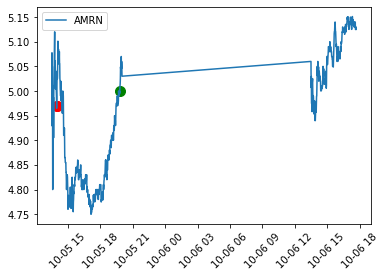

AXGT analysis with profit $15.05


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1148.10,-1148.10,buy,2020-10-05 10:27:02.592449-04:00,5.34,215,13.14%,,"{'buy': {'avg': 5.0053, 'macd': [0.06173164140776333, 0.062168844853110805, 0.06177897467663751, 0.06597062653636243, 0.07130288224940795], 'vwap': 5.34, 'macd_signal': [0.05813257615856841, 0.058939829897476884, 0.05950765885330901, 0.06080025238991969, 0.06290077836181734]}, 'sell': None}",6.65,4.9
1,15.05,1163.15,sell,2020-10-05 11:29:07.927607-04:00,5.41,215,14.62%,,"{'buy': None, 'sell': {'avg': 5.1082, 'rsi': [60.39359119226718, 52.68198332567455, 53.39407739112681], 'vwap': 5.385, 'reasons': 'bail post whipsawed', 'movement': 0.008426966292134819, 'sell_macd': [0.02316892156936934, 0.02220836467926368, 0.021950679249579608, 0.019127149314116743, 0.016938331840845144], 'sell_macd_signal': [0.016089882680090407, 0.017313579079925062, 0.01824099911385597, 0.018418229153908124, 0.018122249691295528]}}",6.65,4.9


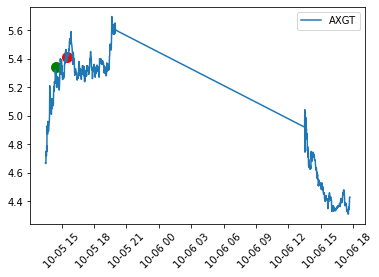

BEEM analysis with profit $4.05


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1325.97,-1325.97,buy,2020-10-05 10:09:25.536016-04:00,16.37,81,5.21%,,"{'buy': {'avg': 15.6494, 'macd': [0.18996125387596585, 0.2026140963514571, 0.20223311428694046, 0.21637413273454698, 0.22659089496290363], 'vwap': 16.38, 'macd_signal': [0.16473166787556112, 0.1723081535707403, 0.17829314571398033, 0.18590934311809365, 0.19404565348705566]}, 'sell': None}",19.82,15.23
1,4.05,1330.02,sell,2020-10-05 10:34:25.368424-04:00,16.42,81,5.53%,,"{'buy': None, 'sell': {'avg': 15.868, 'rsi': [64.59846370380869, 60.73624046744719, 57.76098381531235], 'vwap': 16.41, 'reasons': 'bail post whipsawed', 'movement': 0.0024434941967012304, 'sell_macd': [0.06148296917937657, 0.06299384583403267, 0.06419980367098788, 0.06170834479496534, 0.056887619115013166], 'sell_macd_signal': [0.05543572911920862, 0.05694735246217343, 0.05839784270393632, 0.05905994312214212, 0.05862547832071633]}}",19.82,15.23


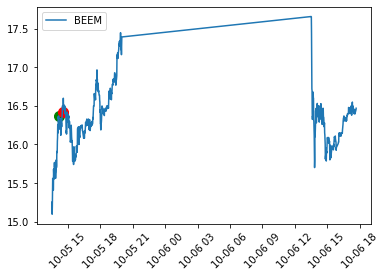

CDE analysis with profit $-27.37


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3022.43,-3022.43,buy,2020-10-05 10:24:21.135033-04:00,7.73,391,0.91%,,"{'buy': {'avg': 7.6507, 'macd': [0.006366223658843317, 0.007215846095050438, 0.011787876823189158, 0.014437896603659794, 0.017147309290882262], 'vwap': 7.73, 'macd_signal': [0.011563847266830496, 0.010694247032474484, 0.010912972990617418, 0.011617957713225893, 0.012723828028757166]}, 'sell': None}",8.45,7.49
1,-27.37,2995.06,sell,2020-10-05 15:46:21.933672-04:00,7.66,391,0.0%,,"{'buy': None, 'sell': {'liquidation': 1}}",8.45,7.49


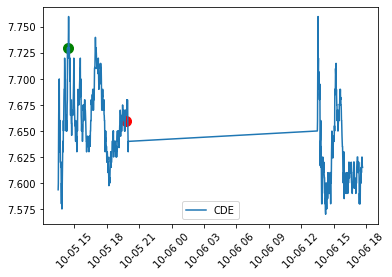

CGC analysis with profit $8.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2529.26,-2529.26,buy,2020-10-05 10:25:44.978135-04:00,14.62,173,1.46%,,"{'buy': {'avg': 14.3979, 'macd': [0.030196081971347155, 0.03144213558355169, 0.034852096270224564, 0.0355311014091253, 0.03948723248479702], 'vwap': 14.627, 'macd_signal': [0.031696116727013855, 0.03164532049832142, 0.03228667565270205, 0.0329355608039867, 0.034245895140148766]}, 'sell': None}",16.25,14.09
1,8.65,2537.91,sell,2020-10-05 11:34:12.942584-04:00,14.67,173,1.8%,,"{'buy': None, 'sell': {'avg': 14.4704, 'rsi': [60.35292076628191, 60.585989092949134, 60.2048458790559], 'vwap': 14.67, 'reasons': 'bail post whipsawed', 'movement': 0.003419972640218927, 'sell_macd': [0.028125382095719687, 0.028993048500058904, 0.026804307406036898, 0.02482341424957646, 0.02288475186467842], 'sell_macd_signal': [0.02222788345127617, 0.023580916461032716, 0.02422559465003355, 0.024345158569942134, 0.024053077228889393]}}",16.25,14.09


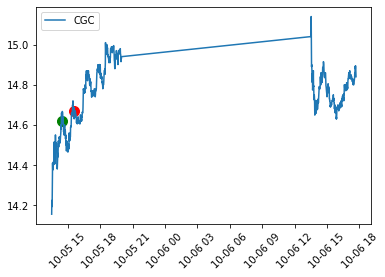

CTIC analysis with profit $0.0


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-784.08,-784.08,buy,2020-10-05 10:13:25.099430-04:00,3.24,242,3.98%,,"{'buy': {'avg': 3.0769, 'macd': [0.03528400540347354, 0.03829771502584922, 0.0429346930487835, 0.050864693573318576, 0.05809344391506732], 'vwap': 3.2415, 'macd_signal': [0.01119456957458067, 0.01661519866483438, 0.021879097541624204, 0.027676216747963077, 0.033759662181383925]}, 'sell': None}",4.4,2.85
1,0.00,784.08,sell,2020-10-05 10:37:22.897718-04:00,3.24,242,3.98%,,"{'buy': None, 'sell': {'avg': 3.1202, 'rsi': [57.96889993128832, 55.99835358388668, 59.48390668486299], 'vwap': 3.2435, 'reasons': 'bail post whipsawed', 'movement': 0.0010802469135801965, 'sell_macd': [0.018958131125706323, 0.01903373840221656, 0.01808702019687125, 0.01659494081352575, 0.01643754206269099], 'sell_macd_signal': [0.018410574003819142, 0.018535206883498627, 0.01844556954617315, 0.01807544379964367, 0.017747863452253133]}}",4.4,2.85


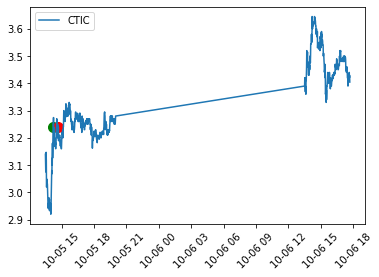

DBD analysis with profit $25.19


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1937.34,-1937.34,buy,2020-10-05 10:25:56.576935-04:00,8.46,229,1.81%,,"{'buy': {'avg': 8.3362, 'macd': [0.021484204187338207, 0.023554169291230664, 0.02809839643198586, 0.030540757907711935, 0.034499408546439625], 'vwap': 8.4508, 'macd_signal': [0.015525962947493996, 0.01713160421624133, 0.019324962659390234, 0.021568121709054575, 0.024154379076531583]}, 'sell': None}",9.69,8.05
1,25.19,1962.53,sell,2020-10-05 15:46:25.545044-04:00,8.57,229,3.13%,,"{'buy': None, 'sell': {'liquidation': 1}}",9.69,8.05


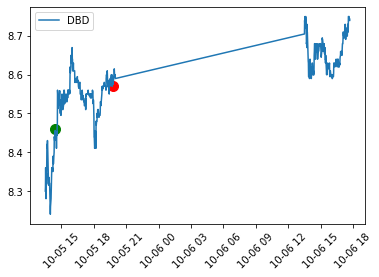

FSM analysis with profit $-28.96


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2403.68,-2403.68,buy,2020-10-05 10:06:39.244926-04:00,6.64,362,1.45%,,"{'buy': {'avg': 6.5432, 'macd': [0.026301002348946945, 0.027585573550096498, 0.029466242456408942, 0.030699629862136035, 0.032424937603236614], 'vwap': 6.645, 'macd_signal': [0.025612446527485885, 0.02600707193200801, 0.026698906036888195, 0.027499050801937763, 0.028484228162197534]}, 'sell': None}",7.42,6.39
1,-28.96,2374.72,sell,2020-10-05 15:47:12.541557-04:00,6.56,362,0.23%,,"{'buy': None, 'sell': {'liquidation': 1}}",7.42,6.39


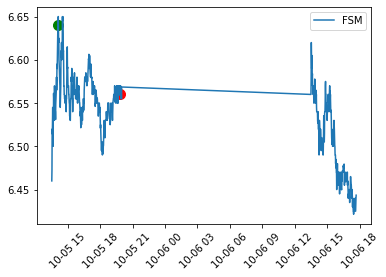

FUV analysis with profit $-35.52


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1447.44,-1447.44,buy,2020-10-05 10:09:37.777024-04:00,6.52,222,3.34%,,"{'buy': {'avg': 6.5159, 'macd': [-0.0003603070501076999, 0.011932728666200099, 0.04057333808876429, 0.050983236205146554, 0.06055243574128433], 'vwap': 6.54, 'macd_signal': [0.002900666522244564, 0.004707078951035671, 0.011880330778581395, 0.01970091186389443, 0.02787121663937241]}, 'sell': None}",7.8,6.12
1,-35.52,1411.92,sell,2020-10-05 15:48:22.923638-04:00,6.36,222,0.81%,,"{'buy': None, 'sell': {'liquidation': 1}}",7.8,6.12


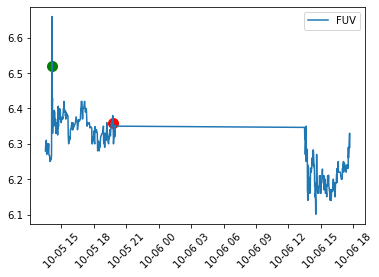

GOCO analysis with profit $-39.25


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2394.25,-2394.25,buy,2020-10-05 10:16:21.169683-04:00,15.25,157,0.79%,,"{'buy': {'avg': 15.0974, 'macd': [0.043215212203765674, 0.043953438670417455, 0.04522750853836044, 0.04890118141451616, 0.05640732191390185], 'vwap': 15.28, 'macd_signal': [0.04250701615815396, 0.042796300660606655, 0.04328254223615741, 0.044406270071829165, 0.0468064804402437]}, 'sell': None}",17.07,14.68
1,-39.25,2355.00,sell,2020-10-05 13:16:34.683220-04:00,15.00,157,-0.86%,,"{'buy': None, 'sell': {'avg': 15.0587, 'rsi': [57.88738080090465, 75.66081131978302, 79.08328197716554], 'vwap': 15.0344, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.014032786885245929, 'sell_macd': [-0.0020676453451997645, -0.0004661860510211113, 0.0010474989321203054, 0.007408195036745724, 0.014055384273639504], 'sell_macd_signal': [-0.007183380018303762, -0.0058399412248472315, -0.004462453193453724, -0.0020883235474138347, 0.0011404180167968333]}}",17.07,14.68


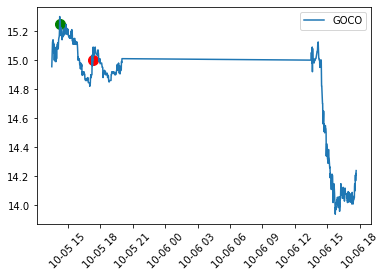

LI analysis with profit $-39.96


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1995.78,-1995.78,buy,2020-10-05 10:14:06.633368-04:00,17.98,111,4.35%,,"{'buy': {'avg': 17.6069, 'macd': [0.12785519937864365, 0.1316032404735168, 0.1362308710695146, 0.1422926230057584, 0.14853140161101308], 'vwap': 17.989, 'macd_signal': [0.10116980191528084, 0.10725648962692803, 0.11305136591544535, 0.11889961733350796, 0.12482597418900898]}, 'sell': None}",20.51,17.15
1,-39.96,1955.82,sell,2020-10-05 13:01:16.653370-04:00,17.62,111,2.26%,,"{'buy': None, 'sell': {'avg': 17.6556, 'rsi': [75.65430975705495, 73.52772098342064, 79.19571959390771], 'vwap': 17.6021, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.018909899888765288, 'sell_macd': [0.0164659600113346, 0.01875741552858301, 0.020559102742950586, 0.021436273263976346, 0.022210220770439548], 'sell_macd_signal': [0.012554413724021288, 0.013795014084933633, 0.015147831816537023, 0.016405520106024887, 0.01756646023890782]}}",20.51,17.15


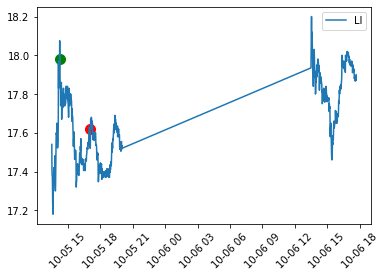

NBLX analysis with profit $10.85


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1757.70,-1757.70,buy,2020-10-05 10:32:32.354009-04:00,8.10,217,3.32%,,"{'buy': {'avg': 7.9088, 'macd': [0.024453434931937856, 0.02583274222597698, 0.028214447459472325, 0.03135436526395363, 0.03983886650377322], 'vwap': 8.1, 'macd_signal': [0.014211885182299155, 0.01653605659103472, 0.01887173476472224, 0.02136826086456852, 0.025062381992409462]}, 'sell': None}",9.4,7.67
1,10.85,1768.55,sell,2020-10-05 12:02:45.443955-04:00,8.15,217,3.95%,,"{'buy': None, 'sell': {'avg': 8.0203, 'rsi': [60.57387185704388, 57.04890885813432, 51.83091644179187], 'vwap': 8.1572, 'reasons': 'bail post whipsawed', 'movement': 0.006790123456790089, 'sell_macd': [0.014114110263765411, 0.016604237827619883, 0.018323762710783953, 0.018132174792329536, 0.015783766352074124], 'sell_macd_signal': [0.01567772362256343, 0.01586302646357472, 0.016355173713016567, 0.01671057392887916, 0.016525212413518155]}}",9.4,7.67


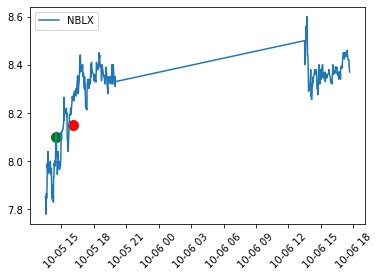

NLS analysis with profit $52.72


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1668.94,-1668.94,buy,2020-10-05 09:59:10.491903-04:00,18.34,91,3.62%,,"{'buy': {'avg': 17.9347, 'macd': [0.09353150627143236, 0.09993163138973671, 0.11098663960049038, 0.11559114301802609, 0.1230187038948074], 'vwap': 18.2191, 'macd_signal': [0.09429567491522743, 0.09542286621012928, 0.0985356208882015, 0.10194672531416642, 0.10616112103029461]}, 'sell': None}",21.29,17.20
1,20.02,1688.96,sell,2020-10-05 10:01:57.269836-04:00,18.56,91,4.86%,,"{'buy': None, 'sell': {'avg': 18.0729, 'rsi': [68.9032869138544, 78.04425333807828, 80.99900997066378], 'vwap': 18.5967, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.013086150490730558, 'sell_macd': [0.058357386862507354, 0.0654677639970096, 0.06833990508886956, 0.08449560067877471, 0.10412736866209116], 'sell_macd_signal': [0.05580747915032335, 0.0577395361196606, 0.05985960991350239, 0.06478680806655686, 0.07265492018566372]}}",21.29,17.20
2,-2008.47,-2028.49,buy,2020-10-05 10:29:49.797648-04:00,18.61,109,5.14%,,"{'buy': {'avg': 18.1671, 'macd': [0.0935202971176139, 0.09597737053883648, 0.09521322725872494, 0.09991125486252983, 0.10644205990980993], 'vwap': 18.61, 'macd_signal': [0.09129469691808065, 0.09223123164223182, 0.09282763076553044, 0.09424435558493031, 0.09668389644990624]}, 'sell': None}",21.20,17.75
3,52.72,2061.19,sell,2020-10-05 11:33:58.780419-04:00,18.91,109,6.84%,,"{'buy': None, 'sell': {'avg': 18.451, 'rsi': [63.7674205640852, 59.20976902214245, 58.4528982606907], 'vwap': 18.91, 'reasons': 'bail post whipsawed', 'movement': 0.01612036539494899, 'sell_macd': [0.07862420824516292, 0.07863550595761382, 0.07788280929253943, 0.07294976241985296, 0.06759739131879883], 'sell_macd_signal': [0.07088558920154732, 0.07243557255276062, 0.07352501990071639, 0.0734099684045437, 0.07224745298739473]}}",21.20,17.75


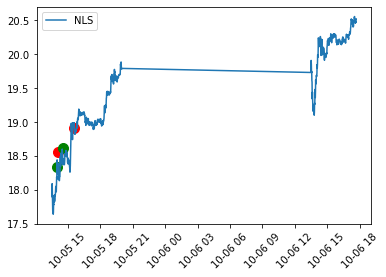

PLG analysis with profit $-36.1


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1559.52,-1559.52,buy,2020-10-05 09:50:29.559896-04:00,2.16,722,6.93%,,"{'buy': {'avg': 2.0624, 'macd': [0.0038957770427221483, 0.00562906175536293, 0.007098398077171719, 0.009835930544945803, 0.014253815748529686], 'vwap': 2.1199, 'macd_signal': [-0.0001494734095854359, 0.0010062336234042371, 0.002224666514157734, 0.0037469193203153476, 0.005848298605958215]}, 'sell': None}",2.51,1.99
1,-36.10,1523.42,sell,2020-10-05 11:45:47.902378-04:00,2.11,722,4.46%,,"{'buy': None, 'sell': {'avg': 2.1203, 'rsi': [53.14429742319585, 63.6719968544603, 80.51729062357758], 'vwap': 2.1338, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.009907407407407549, 'sell_macd': [-0.0012800334421529946, -0.0008707647324750489, -0.00048340255957679545, 0.0006039368291692604, 0.003978435874566699], 'sell_macd_signal': [-0.002150563944957382, -0.0018946041024609154, -0.0016123637938840914, -0.0011691036692734209, -0.0001395957605053969]}}",2.51,1.99


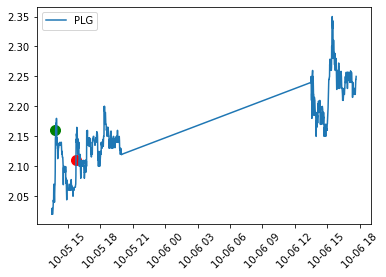

PLM analysis with profit $71.96


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2107.40,-2107.40,buy,2020-10-05 10:20:41.738022-04:00,4.10,514,4.25%,,"{'buy': {'avg': 4.029, 'macd': [0.019385140113161725, 0.020144731498521473, 0.021308004162281513, 0.022527001216084308, 0.023472631372584374], 'vwap': 4.1, 'macd_signal': [0.016575489923253126, 0.017289338238306796, 0.01809307142310174, 0.018979857381698252, 0.019878412179875477]}, 'sell': None}",4.65,3.92
1,71.96,2179.36,sell,2020-10-05 12:35:08.372697-04:00,4.24,514,7.81%,,"{'buy': None, 'sell': {'avg': 4.1135, 'rsi': [78.32545525367959, 78.65491534235535, 79.46926191734217], 'vwap': 4.2978, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.048195121951219624, 'sell_macd': [0.014566908885223384, 0.01701554150444906, 0.02486881962976195, 0.030935415316631243, 0.03592580915943078], 'sell_macd_signal': [0.00664085581327936, 0.0087157929515133, 0.011946398287163032, 0.015744201693056674, 0.019780523186331493]}}",4.65,3.92


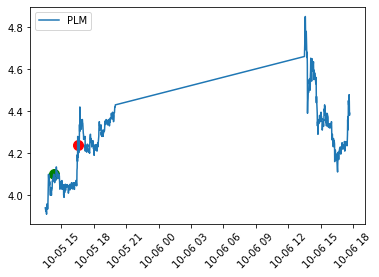

PLUG analysis with profit $-11.28


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2224.98,-2224.98,buy,2020-10-05 10:24:27.420842-04:00,15.78,141,3.95%,,"{'buy': {'avg': 15.329, 'macd': [0.04075628336929249, 0.04893267671936563, 0.05666366664640954, 0.06682938620011747, 0.07526886008179723], 'vwap': 15.7779, 'macd_signal': [0.050876263895464124, 0.05048754646024443, 0.05172277049747745, 0.054744093638005455, 0.05884904692676381]}, 'sell': None}",17.77,15.12
1,-11.28,2213.70,sell,2020-10-05 15:46:12.196651-04:00,15.70,141,3.43%,,"{'buy': None, 'sell': {'liquidation': 1}}",17.77,15.12


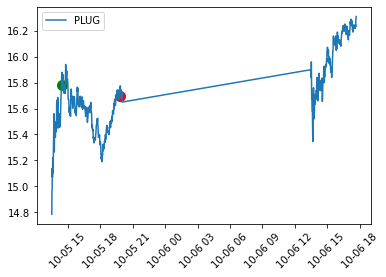

PRVB analysis with profit $36.24


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2130.61,-2130.61,buy,2020-10-05 10:30:46.964353-04:00,14.11,151,3.37%,,"{'buy': {'avg': 13.707, 'macd': [0.06348718799810804, 0.06955021834777675, 0.07988962710210146, 0.08388899718480936, 0.0980322187916638], 'vwap': 14.0709, 'macd_signal': [0.06313578528904458, 0.06441867190079101, 0.0675128629410531, 0.07078808978980436, 0.07623691559017624]}, 'sell': None}",15.97,13.49
1,36.24,2166.85,sell,2020-10-05 11:47:55.895613-04:00,14.35,151,5.13%,,"{'buy': None, 'sell': {'avg': 13.9824, 'rsi': [64.12878719426963, 64.12878719426962, 66.05861967647584], 'vwap': 14.4005, 'reasons': 'bail', 'movement': 0.02055279943302629, 'sell_macd': [0.04689749167429191, 0.047276652316973866, 0.04488019759286921, 0.04242997056638664, 0.0410345992396941], 'sell_macd_signal': [0.041287013340951376, 0.042484941136155877, 0.04296399242749854, 0.04285718805527616, 0.04249267029215975]}}",15.97,13.49


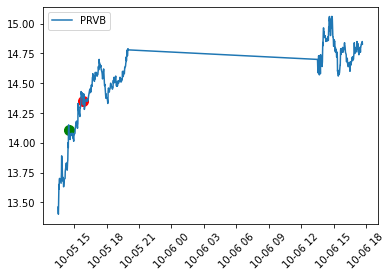

RESN analysis with profit $-39.05


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1960.31,-1960.31,buy,2020-10-05 10:29:23.213445-04:00,2.51,781,3.29%,,"{'buy': {'avg': 2.4427, 'macd': [0.010465705042688622, 0.011969760679286345, 0.013011744318452312, 0.013679831279981514, 0.01564280731787493], 'vwap': 2.5125, 'macd_signal': [0.010291202203007468, 0.010626913898263243, 0.011103879982301057, 0.011619070241837148, 0.012423817657044704]}, 'sell': None}",2.88,2.39
1,-39.05,1921.26,sell,2020-10-05 15:47:33.038027-04:00,2.46,781,1.23%,,"{'buy': None, 'sell': {'liquidation': 1}}",2.88,2.39


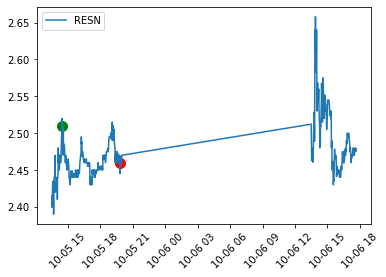

SILV analysis with profit $-32.37


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2186.22,-2186.22,buy,2020-10-05 10:08:46.458546-04:00,8.78,249,2.09%,,"{'buy': {'avg': 8.6061, 'macd': [0.04129363547667353, 0.040362586230427766, 0.04315378598074382, 0.045136021842322904, 0.048280667923704], 'vwap': 8.7776, 'macd_signal': [0.03770645174114956, 0.0382376786390052, 0.03922090010735292, 0.040403924454346915, 0.04197927314821833]}, 'sell': None}",9.91,8.4
1,-32.37,2153.85,sell,2020-10-05 15:46:38.453889-04:00,8.65,249,0.58%,,"{'buy': None, 'sell': {'liquidation': 1}}",9.91,8.4


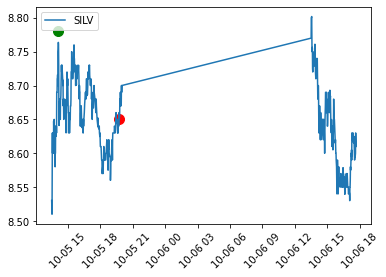

SLDB analysis with profit $243.61


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,6462.83,6462.83,sell,2020-10-05 10:12:40.744121-04:00,4.51,1433,0.67%,,"{'buy': None, 'sell': {'avg': 4.5926, 'vwap': 4.5406, 'vwap_series': [4.557646836187552, 4.583906410653207, 4.596536229476904, 4.60577756649762, 4.606027789301634]}}",4.34,4.61
1,243.61,-6219.22,buy,2020-10-05 10:26:59.161060-04:00,4.34,1433,-3.13%,,"{'buy': {'reason': 'target reached', 'close_5m': [4.61, 4.45, 4.4238, 4.4359, 4.41]}, 'sell': None}",4.34,4.61


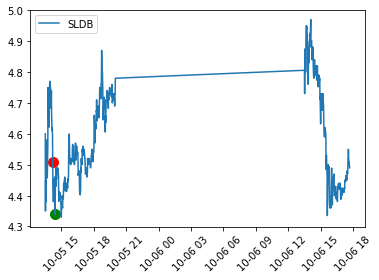

SPI analysis with profit $-43.32


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-413.25,-413.25,buy,2020-10-05 10:05:10.068948-04:00,7.25,57,19.64%,,"{'buy': {'avg': 6.6089, 'macd': [0.14492622617975393, 0.15161484390981883, 0.16071145502129713, 0.1987055354645202, 0.22855382600591145], 'vwap': 7.3299, 'macd_signal': [0.1721214359066438, 0.1680201175072788, 0.16655838501008247, 0.17298781510097, 0.1841010172819583]}, 'sell': None}",12.26,5.71
1,-43.32,369.93,sell,2020-10-05 10:56:23.822692-04:00,6.49,57,7.1%,,"{'buy': None, 'sell': {'avg': 6.8388, 'rsi': [45.99855806112895, 41.199303502697184, 37.48315758954753], 'vwap': 6.48, 'reasons': 'below cost & macd negative & RSI trending down and too far from VWAP', 'movement': -0.10620689655172408, 'sell_macd': [-0.020144924568509026, -0.022020012445017834, -0.02137696387547905, -0.025013848576156406, -0.03141903342634489], 'sell_macd_signal': [-0.026323387500540862, -0.025462712489436257, -0.024645562766644816, -0.024719219928547136, -0.026059182628106685]}}",12.26,5.71


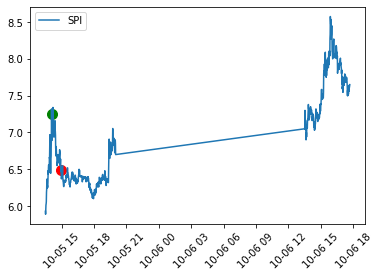

SUNW analysis with profit $37.09


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-975.73,-975.73,buy,2020-10-05 10:22:20.897898-04:00,2.63,371,10.5%,,"{'buy': {'avg': 2.4943, 'macd': [0.024135247132409443, 0.02310404337802252, 0.022830547064722317, 0.026743556539318813, 0.031099976423526243], 'vwap': 2.62, 'macd_signal': [0.02508277907604392, 0.02468703193643964, 0.024315734962096176, 0.024801299277540705, 0.02606103470673781]}, 'sell': None}",3.39,2.38
1,-468.83,506.90,sell,2020-10-05 10:25:46.712823-04:00,2.74,185,15.13%,,"{'buy': None, 'sell': {'avg': 2.5239, 'rsi': [66.32760259724246, 67.28235998286212, 72.99703775250622], 'vwap': 2.7491, 'reasons': 'scale-out', 'movement': 0.04182509505703434, 'sell_macd': [0.01926218292475612, 0.020991132141765956, 0.023618999945386854, 0.025884624208658114, 0.03142297267083505], 'sell_macd_signal': [0.015133066434741323, 0.01630467957614625, 0.01776754364999437, 0.019390959761727118, 0.021797362343548704]}}",3.39,2.38
2,37.09,505.92,sell,2020-10-05 10:33:09.928980-04:00,2.72,186,14.29%,,"{'buy': None, 'sell': {'avg': 2.572, 'rsi': [67.74851938030342, 58.24630231712209, 58.256002736235935], 'vwap': 2.7101, 'reasons': 'bail', 'movement': -0.0109124087591241, 'sell_macd': [0.03817144595783084, 0.03929104519551574, 0.04038565440415942, 0.03733748424980199, 0.034482579139266445], 'sell_macd_signal': [0.03090424901426527, 0.03258160825051536, 0.03414241748124418, 0.03478143083495574, 0.03472166049581788]}}",3.39,2.38


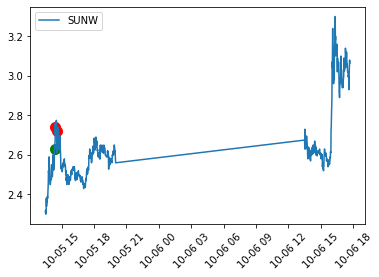

In [7]:
est = pytz.timezone("US/Eastern")
position = {}
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["tstamp"].min().to_pydatetime()
    start_date = start_date.replace(hour=9, minute=30)
    cool_down_date = start_date + timedelta(minutes=5)
    try:
        minute_history_index = minute_history[symbol]["close"].index.get_loc(
            start_date, method="nearest"
        )
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        continue

    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = minute_history[symbol]["close"][cool_minute_history_index]
    plt.plot(
        minute_history[symbol]["close"][minute_history_index:].between_time(
            "9:30", "16:00"
        ),
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    position[symbol] = 0
    for index, row in symbol_df.iterrows():
        if not position[symbol]:
            try:
                now = int(row["client_time"])
                continue
            except Exception:
                pass

        if position[symbol] >= 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]
        elif position[symbol] <= 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] > 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] < 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]

        profit += delta
        plt.scatter(
            row["tstamp"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pytz.utc.localize(pd.to_datetime(row["tstamp"])).astimezone(est))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicators.append(row["indicators"])
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (row['price'] - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (row['indicators']['avg'] - open_price) / open_price, 2)}%"
            if "avg" in row["indicators"]
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit ${round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()